## Data exploration
We resume working on the dataset by exploring more deeply the data in the clean timeseries.

Some analysis that we will be doing:
* Univariate distributions
* Outlier detection
* Missingness
* Correlation

In [1]:
# Data loading
import os
import logging
import time
import sys

import pandas as pd

os.chdir(os.path.dirname(sys.path[0]))

def safe_open_w(path):
    ''' Open "path" for writing, creating any parent directories as needed.
    '''
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return open(path, 'w+')

log_file_name = 'run_logs/data_exploration.log'
safe_open_w(log_file_name).close()  # create empty logfile
logging.basicConfig(
    filename=log_file_name,
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%d-%m-%Y %H:%M:%S',
    )

START_TIME = time.time()

def get_td(current_time=None):
    if not current_time:
        current_time = time.time()
    return '{:.1f} s'.format(current_time-START_TIME)

logging.info(f"Start data analysis - {get_td()}")
wind_df = pd.read_csv(
    "wind/data/example_clean.csv",
    index_col=0,
    low_memory=False,
    )

logging.info(f"Clean dataset loaded - {get_td()}")
wind_df.head()

,Datum (Anlage),Zeit (Anlage),Ereignis,Wind Speed (avg),Rotor Speed [rpm] (avg),Active Power (avg),Nacelle Position (avg),Generator Speed [rpm] (avg),Feature 0,Feature 1,...,Feature 56,Feature 57,Feature 58,Feature 59,Feature 60,Feature 61,Feature 62,Feature 63,Feature 82,datetime
0,2015-01-01,00:00:00,NaN,3.08,0.0,-10.0,244.0,13.43,NaN,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:00:00
1,2015-01-01,00:10:00,NaN,3.43,0.0,-5.0,240.0,14.00,NaN,0.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:10:00
2,2015-01-01,00:20:00,NaN,3.53,0.0,-8.0,239.0,16.31,NaN,0.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:20:00
3,2015-01-01,00:30:00,NaN,3.58,0.0,-7.0,253.0,20.35,NaN,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:30:00
4,2015-01-01,00:40:00,NaN,3.69,0.0,-7.0,260.0,21.69,NaN,0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:40:00


Ereignis
Leistungsbetrieb (10m)             4327
keine Leistung trotz Wind (10m)     190
Name: count, dtype: int64


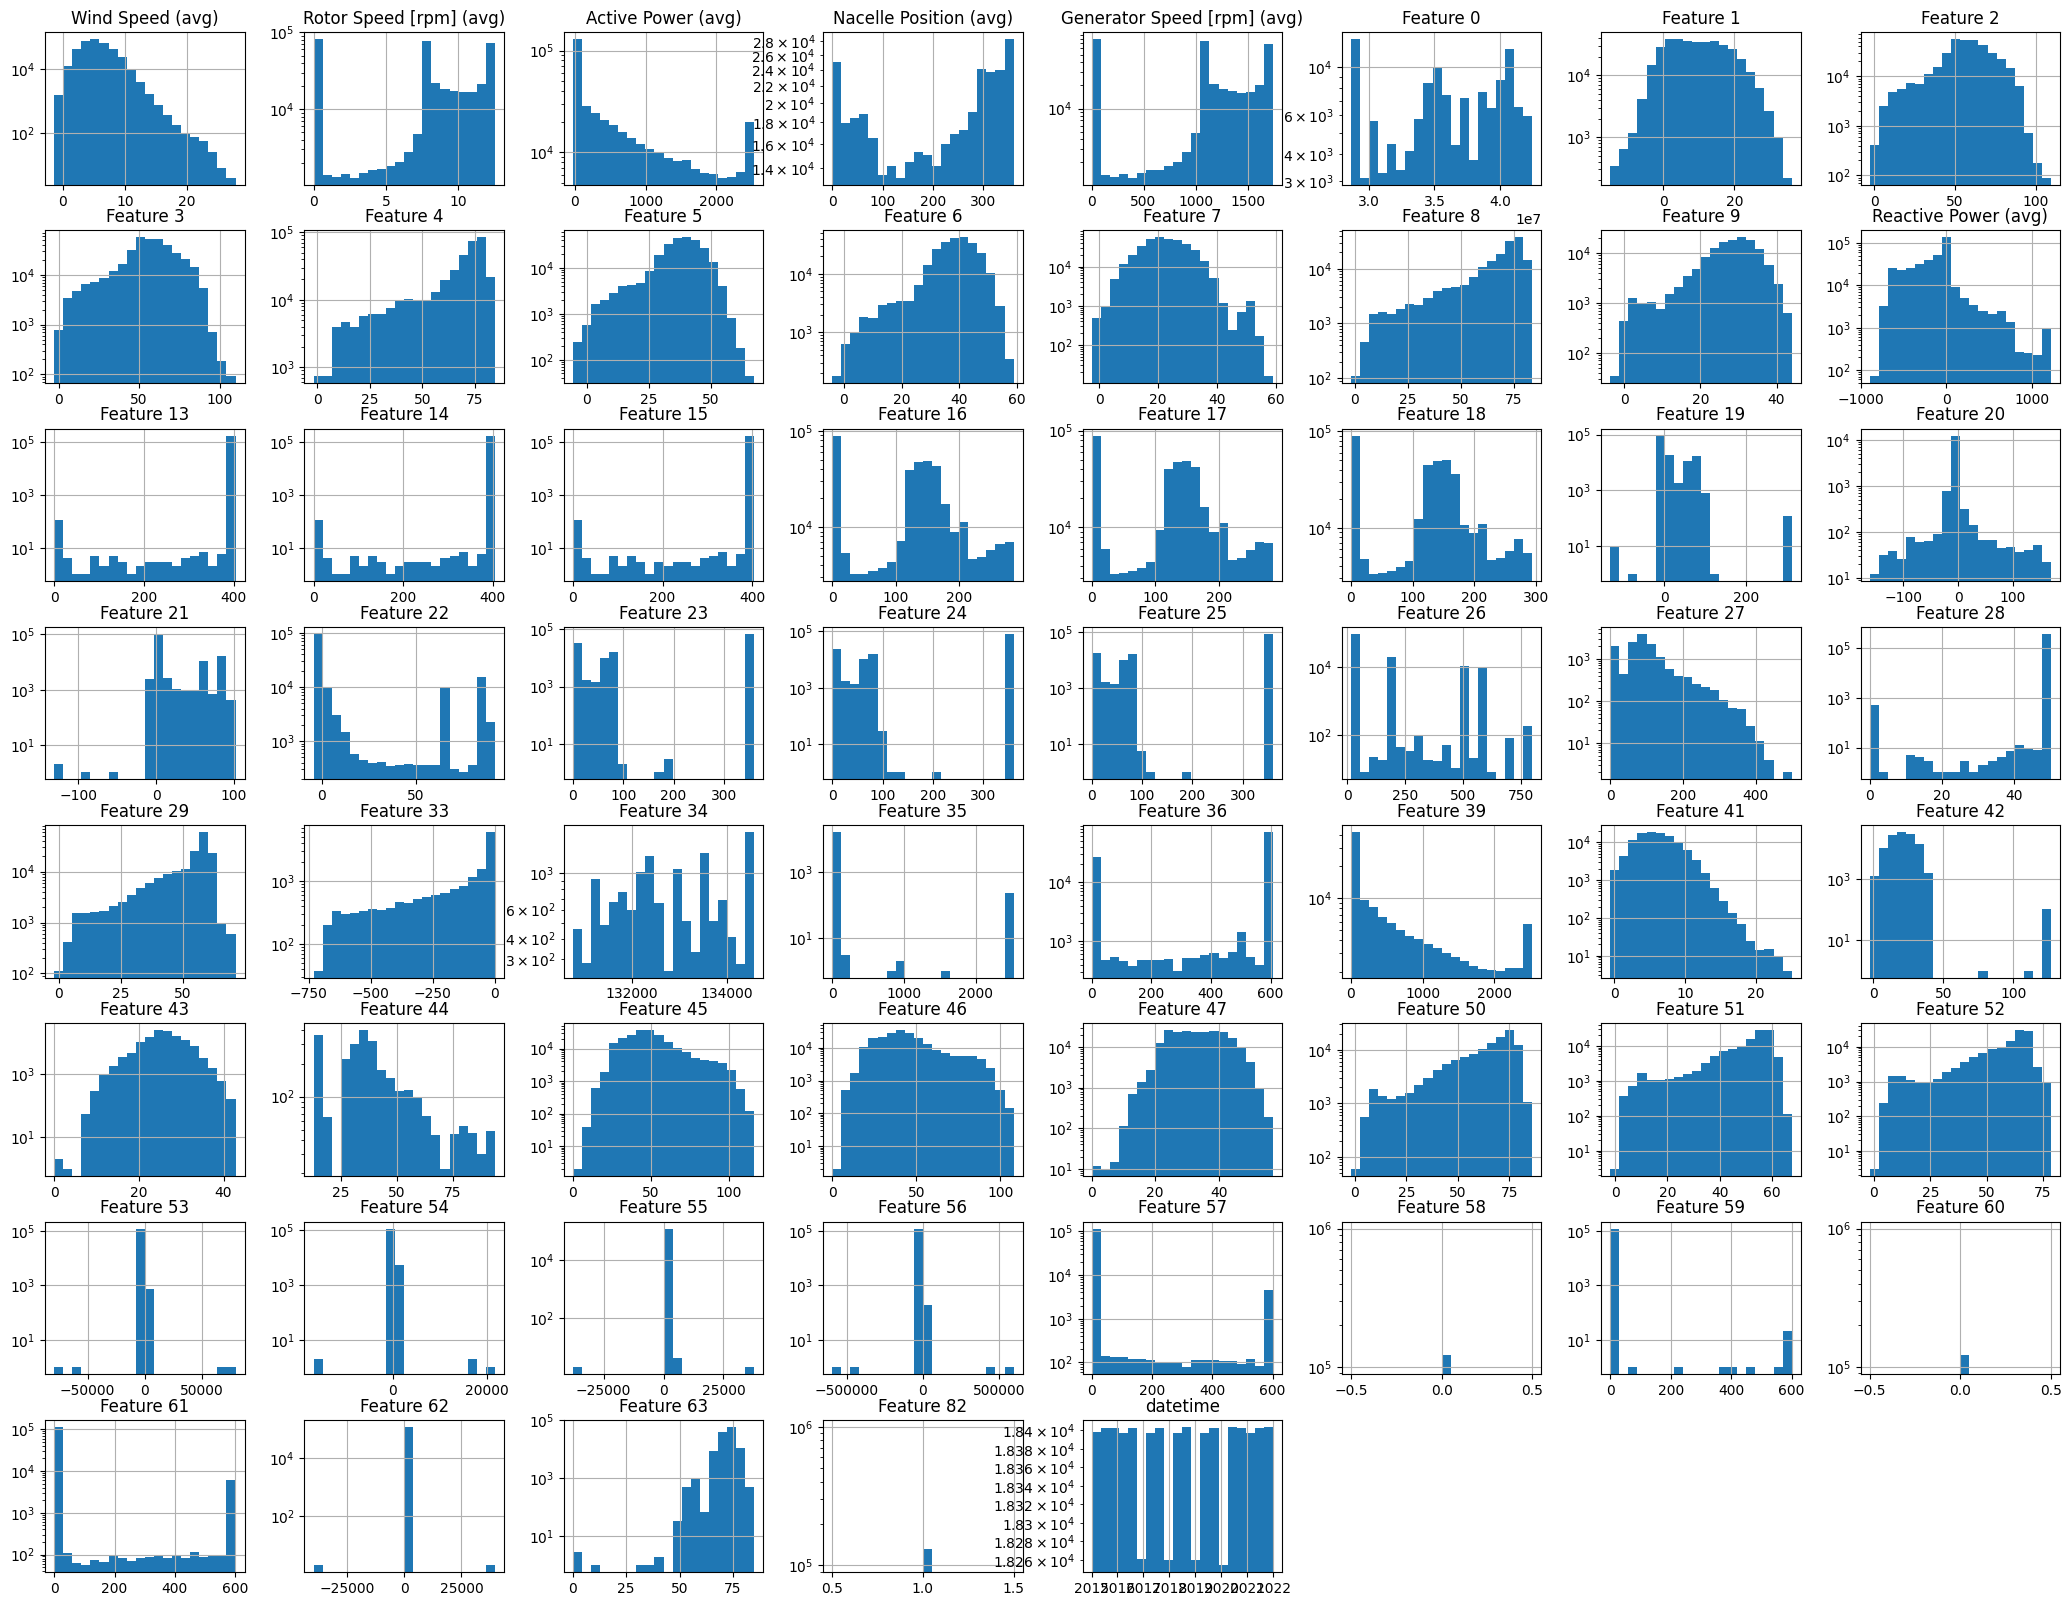

In [41]:
# Univariate data distributions
import seaborn as sns
import matplotlib.pyplot as plt

print(wind_df['Ereignis'].value_counts())

wind_df.hist(bins=20, figsize=(26,20), log=True)
plt.show()

Based on the knowledge that we have from the previous notebook and these histograms, we observe:
* Nacelle position is an angle measurement, which could be encoded as a polar variable
* Datetime is a timeline, which could be encoded as a polar variable for time of the year and time of day
* Ereignis, or Event, column can be encoded as a categorical variable, it has a few observations flagged as 'Leistungsbetrieb (10m)' (Power operation (10m)?) and 'keine Leistung trotz Wind (10m)' (No power output despite wind (10m)?)
* Features [58, 60, 82] are possibly mask features, could be encoded the same as Ereignis column
* Features [19, 21, 23, 24, 25, 35, 42, 43, 53, 54, 55, 56, 59, 62] seem to have multiple modes and are very sparse, these could be discretized and encoded in different ways
* [Wind speed, rotor speed, generator speed, active power, reactive power, nacelle position (polar encoded)] have probably a very strong temporal dynamic (in undetermined timescales) that can be valuable to capture, we can investigate and extract temporal features from these
We will create a sklearn transformer that encodes the new features to add to our dataset.

In [42]:
wind_df.columns

Index(['Datum (Anlage)', 'Zeit (Anlage)', 'Ereignis', 'Wind Speed (avg)',
       'Rotor Speed [rpm] (avg)', 'Active Power (avg)',
       'Nacelle Position (avg)', 'Generator Speed [rpm] (avg)', 'Feature 0',
       'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5',
       'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9',
       'Reactive Power (avg)', 'Feature 13', 'Feature 14', 'Feature 15',
       'Feature 16', 'Feature 17', 'Feature 18', 'Feature 19', 'Feature 20',
       'Feature 21', 'Feature 22', 'Feature 23', 'Feature 24', 'Feature 25',
       'Feature 26', 'Feature 27', 'Feature 28', 'Feature 29', 'Feature 33',
       'Feature 34', 'Feature 35', 'Feature 36', 'Feature 39', 'Feature 41',
       'Feature 42', 'Feature 43', 'Feature 44', 'Feature 45', 'Feature 46',
       'Feature 47', 'Feature 50', 'Feature 51', 'Feature 52', 'Feature 53',
       'Feature 54', 'Feature 55', 'Feature 56', 'Feature 57', 'Feature 58',
       'Feature 59', 'Feature 60', 'Feature 61', '

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

column_types = {
    "angle": ['Nacelle Position (avg)'],
    "datetime": ['datetime'],
    "categorical": [
        'Ereignis',
        'Feature 58',
        'Feature 60',
        'Feature 82',
    ],
    "multimodal": [
        'Feature 19',
        'Feature 21',
        'Feature 23',
        'Feature 24',
        'Feature 25',
        'Feature 35',
        'Feature 42',
        'Feature 43',
        'Feature 53',
        'Feature 54',
        'Feature 55',
        'Feature 56',
        'Feature 59',
        'Feature 62',
    ],
    "timeseries": [
        'Wind Speed (avg)',
        'Rotor Speed [rpm] (avg)',
        'Generator Speed [rpm] (avg)',
        'Active Power (avg)',
        'Reactive Power (avg)',
        'Nacelle Position (avg)',
    ],
    "interactions": [
        ('Wind Speed (avg)', 'Rotor Speed [rpm] (avg)'),
        ('Wind Speed (avg)', 'Active Power (avg)'),
        ('Wind Speed (avg)', 'Nacelle Position (avg)'),
        ('Wind Speed (avg)', 'Reactive Power (avg)'),
        ('Rotor Speed [rpm] (avg)', 'Active Power (avg)'),
        ('Rotor Speed [rpm] (avg)', 'Reactive Power (avg)'),
    ],
}

class CosineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period:float=None):
        self.column_name = None
        self.period = period
        self.is_fit = False
    
    def fit(self, X:pd.Series, y=None):
        self.column_name = f"{X.name}_cosine_{int(self.period)}"
        self.is_fit = True
        return self
    
    def transform(self, X:pd.Series) -> pd.Series:
        data = np.cos((X/self.period)/(2*np.pi))
        return pd.Series(data, name=self.column_name)
    

class MultimodeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_modes:int=3):
        self.column_name = None
        self.max_modes = max_modes
        self.kmeans = None
        self.encoder = None
        self.is_fit = False
    
    def fit(self, X:pd.Series, y=None):
        self.column_name = X.name
        self.encoder = OneHotEncoder(sparse_output=False)
        X = X.values.reshape(-1, 1)
        smallest_distance = np.inf
        for i in range(1, self.max_modes+1):
            kmeans = KMeans(i, n_init='auto').fit(X)
            c = kmeans.cluster_centers_
            l = kmeans.labels_
            distances = np.array([np.abs(x - c[l[i]]) for i, x in enumerate(X)])
            if (median_dist:=np.median(distances)) < smallest_distance:
                smallest_distance = median_dist
                self.kmeans = kmeans
        self.is_fit = True
        self.encoder.fit(l.reshape(-1, 1))
        return self
    
    def transform(self, X:np.ndarray) -> pd.Series | pd.DataFrame:
        X = X.values.reshape(-1, 1)
        prediction = self.kmeans.predict(X).reshape(-1,1)
        oh_cols = pd.DataFrame(self.encoder.transform(prediction), columns = [f"{self.column_name}_mode_{i}" for i in self.encoder.categories_[0]])
        return oh_cols

    def transform(self, X: pd.Series) -> pd.DataFrame:
        if not self.is_fit:
            raise ValueError("Transformer has not been fit.")
        data = []
        for i, centroid in enumerate(self.centroids_):
            values = X.copy().values
            values[values < centroid] = np.nan
            values = self.scalers_[i].transform(values.reshape(-1, 1))
            data.append(values.ravel())
        return pd.DataFrame(np.array(data).T, columns=[f'mode_{i}' for i in range(1, self.max_modes+1)])
    
class TimeseriesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.is_fit = False
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        data = 
        return pd.Series(data, name=self.column_name)
    
class InteractionsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.is_fit = False
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        data = 
        return pd.Series(data, name=self.column_name)
    

class MixedTypesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_types: dict):
        self.column_name = None
        self.column_types = column_types
        self.column_transformer = None
    
    def fit(self, X:pd.DataFrame, y=None):
        transformers = []
        for col, col_type in self.column_types.items():
            if col_type == "angle":
                transformer = CosineTransformer(period=360)
                transformers.append((transformer.column_name, transformer, X[col]))
            elif col_type == "datetime":
                transformer_timeofday = CosineTransformer(period=datetime.timedelta(days=1).total_seconds())
                transformer_timeofyear = CosineTransformer(period=datetime.timedelta(days=365).total_seconds())
                transformers.append((transformer_timeofday.column_name, transformer_timeofday, X[col]))
                transformers.append((transformer_timeofyear.column_name, transformer_timeofyear, X[col]))
            elif col_type == "multimodal":
                transformer = MultimodeTransformer()
                transformers.append((transformer.column_name, transformer, X[col]))
            # add other transformers for different column types here
            
        self.column_transformer = ColumnTransformer(transformers)
        self.column_transformer.fit(X)
        return self
    
    def transform(self, X):
        transformed_columns = self.column_transformer.transform(X)
        transformed_df = pd.DataFrame(transformed_columns, columns=self.column_transformer.get_feature_names())
        return pd.concat([X, transformed_df], axis=1)

In [ ]:
# Check datetime missingness
time_ranges = pd.DataFrame(index=pd.date_range(start=wind_df.datetime.iloc[0], end=wind_df.datetime.iloc[-1], freq='10T'))
time_ranges['is_missing'] = False
time_ranges['is_missing'].loc[~time_ranges.index.isin(wind_df.datetime.values)] = True

bin_size = 24 # in hours
bin_timedelta = pd.Timedelta(f"{bin_size}h").value
group_f = lambda x: pd.to_datetime((x.value//bin_timedelta)*bin_timedelta)
groups = time_ranges.groupby(time_ranges.index.to_series().apply(group_f))
bin_miss_rate = groups.mean()*100

ax = bin_miss_rate.astype(int).plot(figsize=(20,5), title=f'Record missing rate in {bin_size} hour intervals')
ax.set_xlabel('Day')
ax.set_ylabel('Missing records rate (%)')
ax.get_figure()

flag_pct_threshold = 1  # Missing rate percentage above this value is flagged as an event
events = pd.DataFrame.copy(bin_miss_rate.loc[bin_miss_rate.values>flag_pct_threshold], deep=True)
events['week_day'] = list(map(lambda x: x.strftime('%A'), events.index))
events['downtime_hours'] = (events['is_missing']/100*24).round().astype(int)
print("The following missing data events were detected:\n", events[['week_day', 'downtime_hours']])
logging.info(f"datetime missingness checked - {get_td()}")

There seems to be a regular 1 hour down time in the last Sunday of every March. This is probably scheduled maintenance.

There is a full day down time in the last day of the years 2016 to 2020.

In [ ]:
# Check feature level missingness
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

miss_mask = wind_df.isna()
missingness = 100*(miss_mask.sum()/wind_df.shape[0]).sort_values(ascending=False)
print(f"Total missingness: {missingness.mean():.2f}%")
plt.figure(figsize=(12, 6))
plt.title(f'Missingness')
plt.ylabel(f'Missing rate (%)')
plt.axhline(missingness.mean(), color='gray', linestyle='dashed', label='Average missing rate')
missingness.plot(kind='bar')
plt.legend()


distance_metric = 'hamming'  # Normalized Hamming distance
distance_mat = pdist(miss_mask.T, metric=distance_metric)  # Condensed distances (N)*(N-1)/2 array
#distance_mat = squareform(distance_mat)
linkage_mat = linkage(distance_mat, method='complete')
plt.figure(figsize=(12, 6))
correlation_thr = .1  # Increase to have bigger clusters
dend = dendrogram(linkage_mat, labels=list(miss_mask.columns), color_threshold=correlation_thr)
plt.title(f'Miss mask correlation clustering')
plt.ylabel(f'{distance_metric} distance (normalized)')
plt.show()

clustered_cols = [(col, cluster) for col, cluster in zip([miss_mask.columns[i] for i in dend['leaves']], dend['leaves_color_list'])]
clusters = {cluster:[i[0] for i in clustered_cols if i[1]==cluster] for cluster in set(dend['leaves_color_list'])}

There is a high level of feature-level missingness in the dataset (47.52%) and a big variation in these values.

By using the normalized Hamming distance on the missingness mask we can correlate all features identify missingness patterns. This distance metric will attend to the total missingness and also the location of this missingness.

The dendrogram joins a cluster *a* with its counterpair *b* at a level *y*, where *y = dist(a, b)* .

We use the 'complete' linkage method, which means we measure cluster distance based on the distance of their farthest members.
Variables like *datetime*, *Datum* and *Zeit* were alligned together in the data cleaning step, this leads to a 0 distance in the Hamming distances which also means they are joined at the same level.

Due to the high correlation found, we know that these columns most likely are not missing completely at random.

Finally regarding imputation, a model could be built 

In [ ]:
# Missingness correlation check
from phik import phik_matrix

corr_threshold=.975

plot_graphs=True
for i, col_i in enumerate(miss_mask.columns):
    if plot_graphs and not (collinear:=corr.iloc[i,i+1:].loc[corr[col_i]>corr_threshold]).empty:
        g = sns.pairplot(corr_df, vars=[col_i] + list(collinear.index), diag_kind='kde', corner=True)
        g.fig.suptitle(f"{col_i} correlation cluster", y=1.03, fontsize=12)
        seen += list(collinear.index)

logging.info(f"Multicollinearity checked - {get_td()}")